# Lateral offset analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = 'offset'  # Analysis type
mouseline = 'sst' # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # whether to smooth the baseline with an extra moving average
ykey_postpro = Label.DFF  # variable of interest for post-processing

### Derived parameters

In [4]:
# Get batch-related settings
dataset_group_id, trialavg_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, kalman_gain,
    baseline_wlen, baseline_quantile, baseline_smoothing,
    ykey_postpro)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 17/10/2022 18:25:26: assembling batch analysis settings...
 17/10/2022 18:25:26: sst batch notebook started on 2022-10-17 at 18:25:26


### Input summary table figure

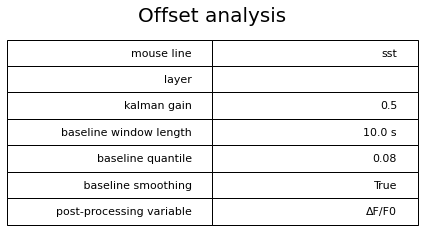

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'post-processing variable': ykey_postpro
    }, title='Offset analysis')

## Input data

### Load data

In [6]:
# Determine what to do in case of duplicate runs
on_duplicate_runs = 'pass'

# Load datasets
logger.info(f'loading data from {trialavg_dir}:')
data = load_trialavg_datasets(
    trialavg_dir, layer=layer, include_mode='any',
    on_duplicate_runs=on_duplicate_runs, harmonize_runs=False, 
    condition='offset')

 17/10/2022 18:25:26: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w10.0s_q0.08_smooth/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/offset/sst:
 17/10/2022 18:25:27: loading trial-averaged data from 20190518_mouse6_region1.h5
 17/10/2022 18:25:27: loading trial-averaged data from 20190518_mouse7_region1.h5
 17/10/2022 18:25:27: loading trial-averaged data from 20190601_mouse2_region1.h5
 17/10/2022 18:25:27: loading trial-averaged data from 20190601_mouse7_region1.h5
 17/10/2022 18:25:27: loading trial-averaged data from 20190601_mouse8_region1.h5
 17/10/2022 18:25:27: gathering dataset IDs...
 17/10/2022 18:25:27: duplicated runs in 20190518_mouse7_region1:
run
0    0.0x_-1.5y
1    0.0x_-1.5y
Name: offset (mm), dtype: object
 17/10/2022 18:25:27: duplicated runs in 20190601_mouse7_region1:
run
4    0.0x_0.0y
5    0.0x_0.0y
Name: offset (mm), dtype: object
 17/10/2022 18:25:27: duplicated runs in 20190601_mouse8_region1:
run
4 

### Breakdown per mouse region, cell maps & filter out datasets

 17/10/2022 18:25:29: extracting timeseries and stats from data...
 17/10/2022 18:25:29: plotting cells map color-coded by response type...
 17/10/2022 18:25:29: extracting responses types per ROI...
 17/10/2022 18:25:29: plotting cells map color-coded by response type...
 17/10/2022 18:25:29: extracting responses types per ROI...
 17/10/2022 18:25:30: plotting cells map color-coded by response type...
 17/10/2022 18:25:30: extracting responses types per ROI...
 17/10/2022 18:25:31: plotting cells map color-coded by response type...
 17/10/2022 18:25:31: extracting responses types per ROI...
 17/10/2022 18:25:31: plotting cells map color-coded by response type...
 17/10/2022 18:25:31: extracting responses types per ROI...
 17/10/2022 18:25:32: identifying datasets to use for variable offset analysis...


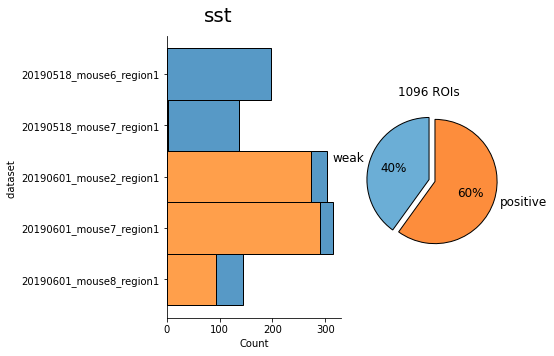

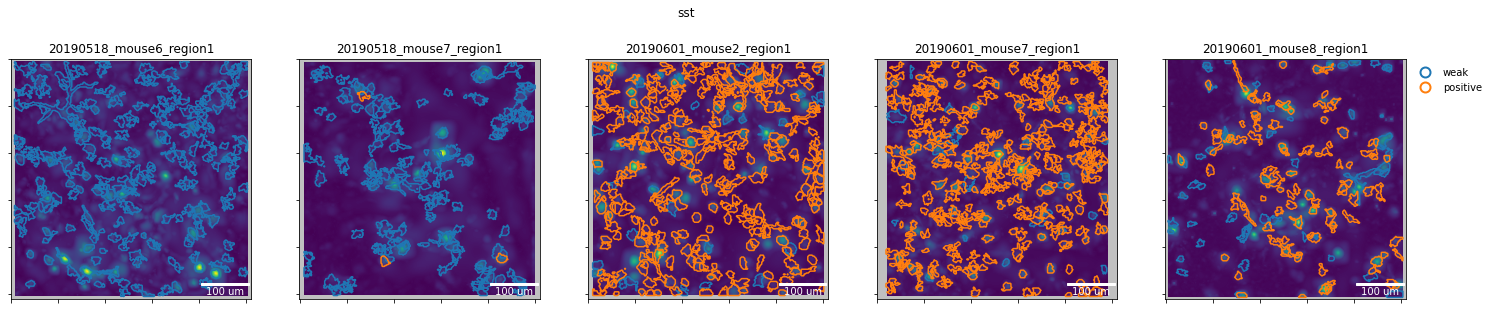

In [7]:
# Extract fields from data
timeseries, stats, ROI_masks, map_ops = extract_from_batch_data(data)
# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, title=mouseline, count='pie')
# Plot cell maps
figs['cellmaps'] = plot_cell_maps(
    ROI_masks, stats, map_ops, title=mouseline, refkey='Vcorr', mode='contour')

# Compute number of runs per dataset
logger.info('identifying datasets to use for variable offset analysis...')
nruns_per_dataset = stats.groupby([Label.DATASET]).apply(
    lambda df: len(df.index.unique(level=Label.RUN)))
# Identify datasets for variable offset analysis
varoffset_datasets = nruns_per_dataset.loc[nruns_per_dataset > 5].index.values.tolist()
idx_varoffset = pd.IndexSlice[varoffset_datasets]

### Add transducer location info to stats

In [8]:
logger.info('adding parsed 2D offset info to stats...')
offsets_2d = get_offset_complex(stats)
stats['xoff (mm)'] = offsets_2d.apply(np.real)
stats['yoff (mm)'] = offsets_2d.apply(np.imag)

 17/10/2022 18:25:33: adding parsed 2D offset info to stats...


### Plot response strength vs. XY offset

 17/10/2022 18:25:33: grouping stats by dataset...
 17/10/2022 18:25:33: plotting map of "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" vs. XY offset...
 17/10/2022 18:25:33: found max "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" values at offset coordinates:
                         xoff (mm)  yoff (mm)
dataset                                      
20190518_mouse6_region1        0.0        0.0
20190518_mouse7_region1        0.0        0.0
20190601_mouse2_region1        0.5        0.0
20190601_mouse7_region1       -0.5        0.0
20190601_mouse8_region1       -1.0        0.0
 17/10/2022 18:25:33: grouping stats by dataset...
 17/10/2022 18:25:33: plotting map of "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" vs. XY offset...
 17/10/2022 18:25:33: found max "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" values at offset coordinates:
                         xoff (mm)  yoff (mm)
dataset                                      
20190518_mouse6_region1        0.0        0.0
20190518_mouse7_region1        0

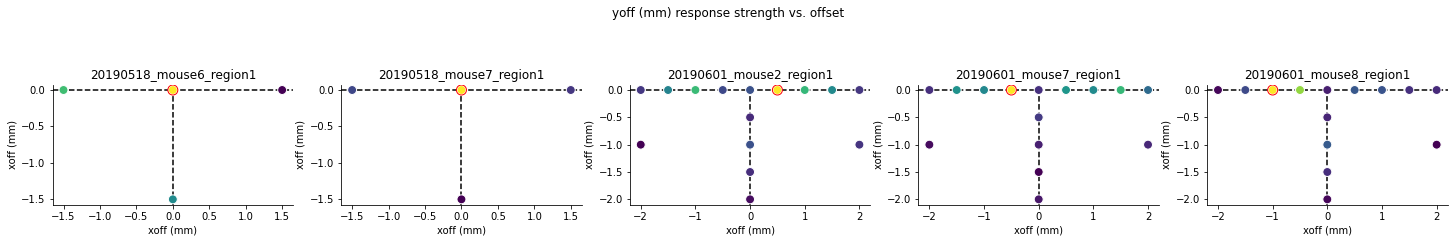

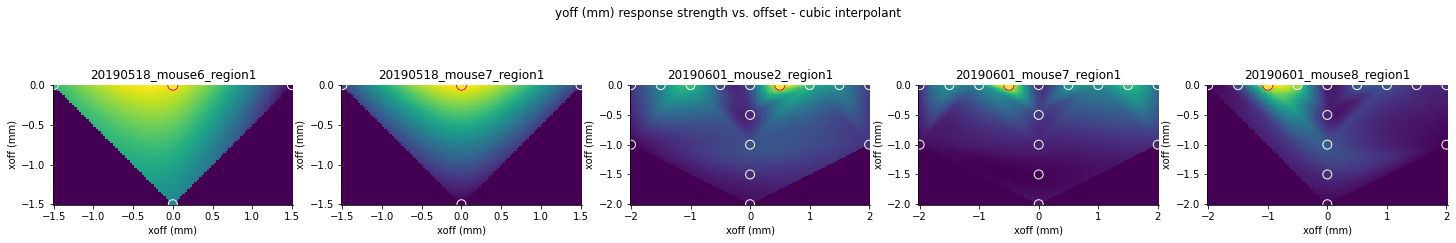

In [9]:
# Keys for coordinates and output metrics of interest
xykeys = ['xoff (mm)', 'yoff (mm)']
outkey = get_change_key(ykey_postpro)

# Plot map of response strength across XY offsets 
for interp in [None, 'cubic']:
    figs[f'resp_vs_offset_loc_{interp}'], max_resp_offset_coords = plot_stat_vs_offset_map(
        stats, *xykeys, outkey, interp=interp)

### Correct offset origins for each dataset (max response at origin)

 17/10/2022 18:25:34: grouping stats by dataset...
 17/10/2022 18:25:34: plotting map of "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" vs. XY offset...
 17/10/2022 18:25:34: found max "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" values at offset coordinates:
                         corrected xoff (mm)  corrected yoff (mm)
dataset                                                          
20190518_mouse6_region1                  0.0                  0.0
20190518_mouse7_region1                  0.0                  0.0
20190601_mouse2_region1                  0.0                  0.0
20190601_mouse7_region1                  0.0                  0.0
20190601_mouse8_region1                  0.0                  0.0
 17/10/2022 18:25:34: grouping stats by dataset...
 17/10/2022 18:25:34: plotting map of "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" vs. XY offset...
 17/10/2022 18:25:34: found max "post-stim avg ΔF/F0 - pre-stim avg ΔF/F0" values at offset coordinates:
                         corre

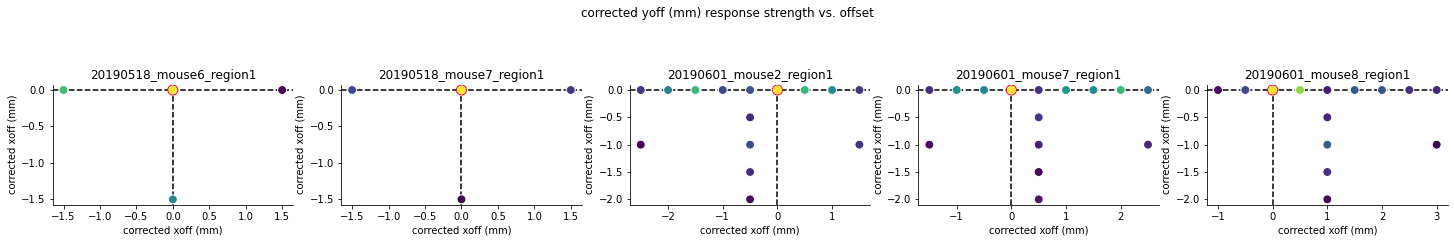

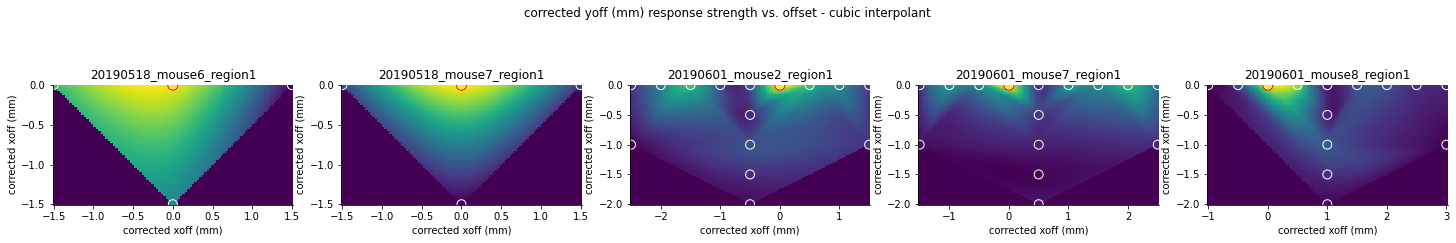

In [10]:
# Apply corrections
for k in xykeys:
    stats[f'corrected {k}'] = stats[k] - max_resp_offset_coords[k]

# Plot map of response strength across corrected XY offsets 
corrected_xykeys = [f'corrected {x}' for x in xykeys]
for interp in [None, 'cubic']:
    figs[f'resp_vs_offset_loc_corrected_{interp}'], _ = plot_stat_vs_offset_map(
        stats, *corrected_xykeys, outkey, interp=interp)

### Plot response strength vs. normalized offset distance

 17/10/2022 18:25:34: plotting offset dependency of response...
 17/10/2022 18:25:34: corrected offset (mm) no part of (P (MPa), DC (%)) -> no filtering
 17/10/2022 18:25:34: sub-indexing data...
 17/10/2022 18:25:34: filtering data...
 17/10/2022 18:25:34: cross-checking filters...
 17/10/2022 18:25:34: grouping by dataset, averaging, estimating confidence intervals and plotting mean post-stim avg ΔF/F0 - pre-stim avg ΔF/F0 vs. corrected offset (mm) ...
 17/10/2022 18:25:35: rounded corrected offset (mm) no part of (P (MPa), DC (%)) -> no filtering
 17/10/2022 18:25:35: sub-indexing data...
 17/10/2022 18:25:35: filtering data...
 17/10/2022 18:25:35: cross-checking filters...
 17/10/2022 18:25:35: grouping by dataset, averaging, estimating confidence intervals and plotting mean post-stim avg ΔF/F0 - pre-stim avg ΔF/F0 vs. rounded corrected offset (mm) ...


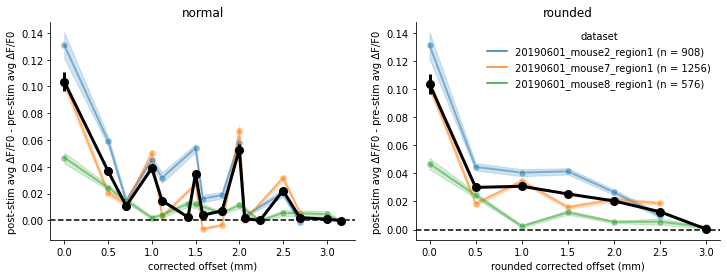

In [11]:
# Compute (corrected) offset distance as XY norm, and rounded to nearest .5 mm
dkey = f'corrected {Label.OFFSET}'
stats[dkey] = np.linalg.norm(stats[corrected_xykeys], axis=1)
rounded_dkey = f'rounded {dkey}'
stats[rounded_dkey] = stats[dkey].apply(round_to_base)

# Plot response strength vs. distance
logger.info(f'plotting offset dependency of response...')
figs['resp_vs_offset'], axes = plt.subplots(1, 2, figsize=(12, 4))
for i, (ax, k, title) in enumerate(zip(axes, [dkey, rounded_dkey], ['normal', 'rounded'])):
    plot_parameter_dependency(
        stats.loc[idx_varoffset, :], xkey=k, ykey=outkey, yref=0., hue=Label.DATASET,
        avgprop='whue', errprop='intra', ax=ax, legend=i == len(axes) - 1, title=title)

### Plot normalized response strength vs. normalized offset distance

 17/10/2022 18:25:36: plotting offset dependency of normalized response...
 17/10/2022 18:25:36: corrected offset (mm) no part of (P (MPa), DC (%)) -> no filtering
 17/10/2022 18:25:36: sub-indexing data...
 17/10/2022 18:25:36: filtering data...
 17/10/2022 18:25:36: cross-checking filters...
 17/10/2022 18:25:36: grouping by dataset, averaging, estimating confidence intervals and plotting mean normalized post-stim avg ΔF/F0 - pre-stim avg ΔF/F0 vs. corrected offset (mm) ...
 17/10/2022 18:25:37: rounded corrected offset (mm) no part of (P (MPa), DC (%)) -> no filtering
 17/10/2022 18:25:37: sub-indexing data...
 17/10/2022 18:25:37: filtering data...
 17/10/2022 18:25:37: cross-checking filters...
 17/10/2022 18:25:37: grouping by dataset, averaging, estimating confidence intervals and plotting mean normalized post-stim avg ΔF/F0 - pre-stim avg ΔF/F0 vs. rounded corrected offset (mm) ...


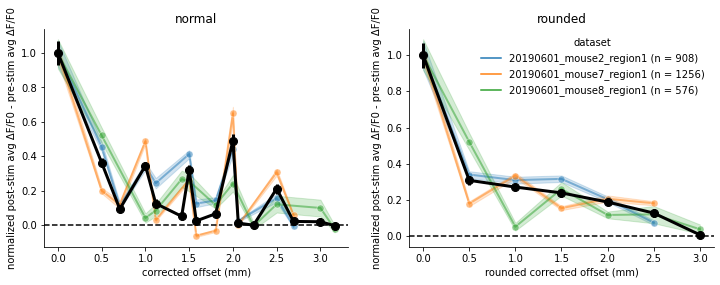

In [12]:
# Compute normalized response strength for each dataset
maxperdataset = stats.groupby([Label.DATASET, dkey])[outkey].mean().groupby(Label.DATASET).max()
normkey = f'normalized {outkey}'
stats[normkey] = stats[outkey] / maxperdataset

# Plot normalized response strength vs. distance
logger.info(f'plotting offset dependency of normalized response...')
figs['resp_vs_offset'], axes = plt.subplots(1, 2, figsize=(12, 4))
for i, (ax, k, title) in enumerate(zip(axes, [dkey, rounded_dkey], ['normal', 'rounded'])):
    plot_parameter_dependency(
        stats.loc[idx_varoffset, :], xkey=k, ykey=normkey, yref=0., hue=Label.DATASET,
        avgprop='whue', errprop='intra', ax=ax, legend=i == len(axes) - 1, title=title)

### Plot responders traces vs variable offset

 17/10/2022 18:25:38: assembling plot data...
 17/10/2022 18:25:38: adding time info to table...
 17/10/2022 18:25:39: plotting responders traces across offset & datasets...
 17/10/2022 18:25:44: plotting aggregate responders traces across offset...


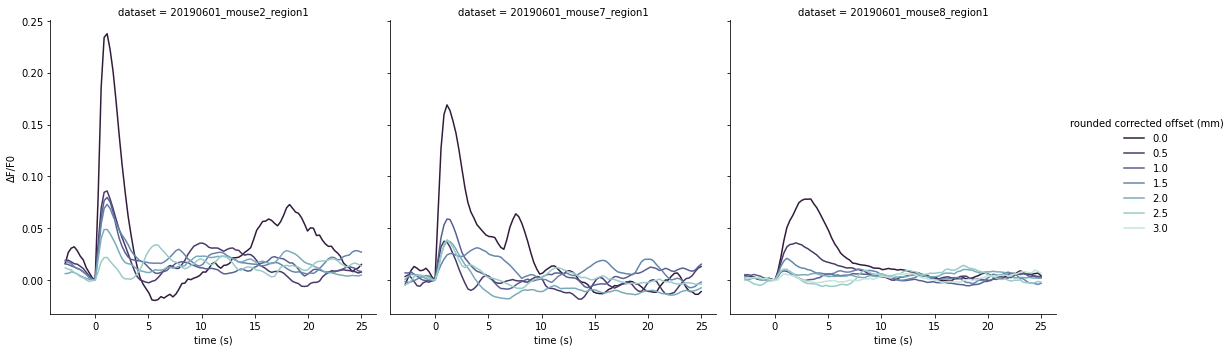

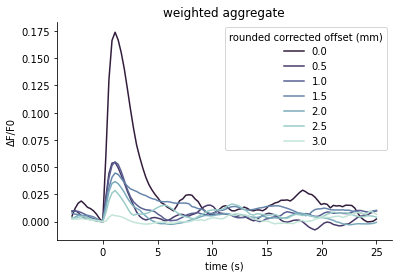

In [13]:
# Get plot data
logger.info('assembling plot data...')
pltdata = expand_and_add(
    stats[[Label.ROI_RESP_TYPE, rounded_dkey]], timeseries.copy())
# Add time
fps = get_singleton(stats, Label.FPS)
pltdata = add_time_to_table(pltdata, fps=fps)
# Restricd to variable offset datasets
pltdata = pltdata.loc[idx_varoffset, :]

# Plot parameters
palette = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
ci = None

# Plot response traces vs. offset for each dataset
logger.info('plotting responders traces across offset & datasets...')
fg = sns.relplot(
    data=pltdata, x=Label.TIME, y=ykey_postpro, kind='line',
    hue=rounded_dkey, col=Label.DATASET, ci=ci, palette=palette)
figs['traces_vs_offset_per_dataset'] = fg.figure

# Plot weighted aggregate response traces vs. offset
logger.info('plotting aggregate responders traces across offset...')
figs['traces_vs_offset_agg'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('weighted aggregate')
sns.lineplot(
    data=pltdata, x=Label.TIME, y=ykey_postpro, ax=ax,
    hue=rounded_dkey, ci=ci, palette=palette);

### Plot comparison of centered vs. 1.5 mm offset

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

20190518_mouse7_region1_0.0 vs. 20190518_mouse7_region1_1.5: t-test independent samples, P_val:2.640e-34 t=1.293e+01
20190518_mouse6_region1_0.0 vs. 20190518_mouse6_region1_1.5: t-test independent samples, P_val:2.479e-02 t=2.249e+00
20190601_mouse2_region1_0.0 vs. 20190601_mouse2_region1_1.5: t-test independent samples, P_val:1.622e-34 t=1.265e+01
20190601_mouse7_region1_0.0 vs. 20190601_mouse7_region1_1.5: t-test independent samples, P_val:3.196e-114 t=2.527e+01
20190601_mouse8_region1_0.0 vs. 20190601_mouse8_region1_1.5: t-test independent samples, P_val:1.774e-18 t=9.184e+00


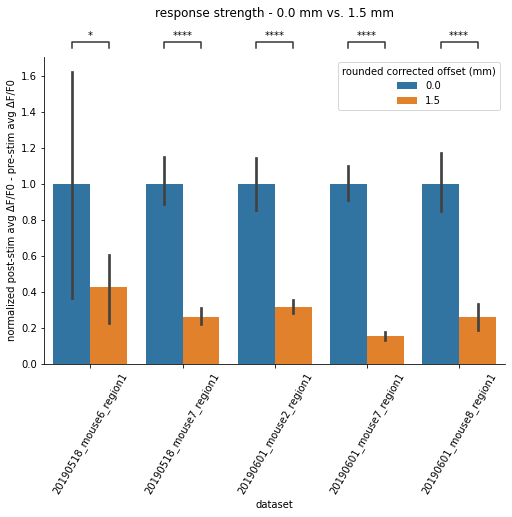

In [14]:
# Plot paired-comparisons of response strength between center and 1.5 mm offset
fixed_offsets = (0., 1.5)  # comparative offset values (mm)
figs['paired_comps'] = plot_center_vs_offset_comp(
    stats, rounded_dkey, fixed_offsets, outkey)

### Save figures

In [15]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 17/10/2022 18:25:49: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.10.17/figs_offset_sst_k0.5_w10.0s_q0.08_smooth_ΔFF0.pdf:


100%|██████████| 11/11 [00:07<00:00,  1.39it/s]


### Notify upon completion

In [16]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 17/10/2022 18:25:57: sst batch notebook completed in 0:00:31.040624 s
